# 🗳️ Elecciones EEUU

🧑‍💻 Lucía Cordero | Jorge Garcelán

![Election Results](https://www.porunmundomasjusto.es/wp-content/uploads/2020/11/mundomasjusto.png)


<div class="warning" style='padding:0.1em; border-left: 4px solid #17a2b8; background-color:#e8f8ff;'>
<span>
<p style='margin-top:1em; margin-left:1em; text-align:left'>
<b>🎯Motivación y Objetivos</b></p>
<p style='margin-left:1em;'>
Este proyecto de análisis de datos está basado en los resultados de las <strong>elecciones presidenciales de Estados Unidos de 2020</strong>. Inspirados por nuestro interés en la política y teniendo en cuenta que las elecciones presidenciales de EE.UU. de 2024 son el 5 de noviembre, se nos ocurrió abordar este tema.
<br><br>
    El objetivo es aplicar técnicas de <strong>aprendizaje supervisado</strong> y <strong>no supervisado</strong> para explorar patrones y tendencias, así como predecir los resultados electorales en función de las características socioeconómicas y demográficas de cada condado. Este enfoque nos permite estudiar cómo estos factores influyen en los comportamientos de los votantes y cómo podrían anticiparse los resultados de futuras elecciones.
</p>
</span>
</div>

<div style="border-left: 4px solid #ffa500; background-color: #fff4e5; padding: 10px;">
    <strong>⚠️Warning:</strong> Es importante mencionar que no hemos podido utilizar los datos de 2024 como test pues no se encuentran disponibles todavía.
</div>


## Librerías

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objs as go
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression


## Datasets

In [2]:
# Cargar datos de state, county, fips
state_fips_county = pd.read_csv('data/state_fips_county.csv')
state_names = state_fips_county['state']
fips_codes = state_fips_county['fips'].astype(str).str.zfill(5)
county_names = state_fips_county['county']

### Seleccionar año

In [93]:
CENSUS_YEAR = 2023 # 2015, 2019, 2023
ELECTORAL_YEAR = CENSUS_YEAR + 1

### Cargar datos

In [85]:
data = pd.read_csv(f'data/final_data_{ELECTORAL_YEAR}.csv')

In [87]:
# Volver a definir el diccionario de mapeo de FIPS y nombres de condados en Connecticut
fips_mapping = {
    "09110": ("09001", "Capitol Planning Region"),
    "09120": ("09003", "Greater Bridgeport Planning Region"),
    "09130": ("09005", "Lower Connecticut River Valley Planning Region"),
    "09140": ("09007", "Naugatuck Valley Planning Region"),
    "09150": ("09009", "Northeastern Connecticut Planning Region"),
    "09160": ("09011", "Northwest Hills Planning Region"),
    "09170": ("09013", "South Central Connecticut Planning Region"),
    "09180": ("09015", "Southeastern Connecticut Planning Region"),
}

# Actualizar los valores de 'county_fips' y 'county' en el dataframe
for old_fips, (new_fips, new_county) in fips_mapping.items():
    data.loc[data['county_fips'] == old_fips, ['county_fips', 'county']] = [new_fips, new_county]

data['county_fips'] = data['county_fips'].astype(str).str.zfill(5)
fips_codes = state_fips_county['fips'].astype(str).str.zfill(5)

# Mostrar la tabla actualizada
data[data['state'] == "Connecticut"]

state county_fips                                          county  \
279  Connecticut       09003              Greater Bridgeport Planning Region   
280  Connecticut       09005  Lower Connecticut River Valley Planning Region   
281  Connecticut       09007                Naugatuck Valley Planning Region   
282  Connecticut       09009        Northeastern Connecticut Planning Region   
283  Connecticut       09011                 Northwest Hills Planning Region   
284  Connecticut       09013       South Central Connecticut Planning Region   
285  Connecticut       09015        Southeastern Connecticut Planning Region   

     votes_gop  votes_dem  total_votes  votes_others  per_votes_others  \
279   159024.0   283368.0     449336.0        6944.0          0.015454   
280    55601.0    50164.0     107544.0        1779.0          0.016542   
281    40665.0    56848.0      99203.0        1690.0          0.017036   
282   169892.0   242629.0     417980.0        5459.0          0.013060   
283    57110.0    79459.0     139604.0        3035.0          0.021740   
284    34819.0    44006.0      80546.0        1721.0          0.021367   
285    29141.0    26701.0      57077.0        1235.0          0.021637   

      per_dem   per_gop  ...  households_owner_rate  unemployment_rate  \
279  0.630637  0.353909  ...                  64.11               5.84   
280  0.466451  0.517007  ...                  76.49               4.98   
281  0.573047  0.409917  ...                  73.52               4.65   
282  0.580480  0.406460  ...                  61.85               6.44   
283  0.569174  0.409086  ...                  66.37               5.93   
284  0.546346  0.432287  ...                  71.76               4.89   
285  0.467807  0.510556  ...                  68.97               5.54   

     public_transport_rate  no_health_insurance_rate  winner  delta_per_dem  \
279                   1.57                      4.00     dem       4.502129   
280                   0.74                      3.84     gop       5.759982   
281                   0.79                      3.17     dem       6.054747   
282                   1.88                      4.94     dem       3.885682   
283                   0.74                      3.84     dem       6.365334   
284                   0.95                      2.52     dem       4.744261   
285                   0.29                      4.06     gop       3.832516   

     delta_per_gop  delta_per_oth   latitude  longitude  
279      -1.659453      -2.842676  41.803893 -72.732326  
280      -3.080999      -2.678983  41.791253 -73.245934  
281      -2.951872      -3.102875  41.459774 -72.539468  
282      -1.484711      -2.400971  41.417930 -72.928288  
283      -2.916464      -3.448870  41.488418 -72.110085  
284      -0.873324      -3.870936  41.861181 -72.336335  
285       0.293309      -4.125825  41.829834 -71.986423  

[7 rows x 52 columns]

## Análisis Exploratorio de Datos

#### Ganador por condado

In [88]:
plot_data = data.copy()
plot_data['county_fips'] = plot_data['county_fips'].astype(str).str.zfill(5)
plot_data['state'] = state_names
plot_data

state county_fips             county  votes_gop  votes_dem  \
0     Alabama       01001     Autauga County    19838.0     7503.0   
1     Alabama       01003     Baldwin County    83544.0    24578.0   
2     Alabama       01005     Barbour County     5622.0     4816.0   
3     Alabama       01007        Bibb County     7525.0     1986.0   
4     Alabama       01009      Blount County    24711.0     2640.0   
...       ...         ...                ...        ...        ...   
3102  Wyoming       56037  Sweetwater County    12229.0     3823.0   
3103  Wyoming       56039       Teton County     4341.0     9848.0   
3104  Wyoming       56041       Uinta County     7496.0     1591.0   
3105  Wyoming       56043    Washakie County     3245.0      651.0   
3106  Wyoming       56045      Weston County     3107.0      360.0   

      total_votes  votes_others  per_votes_others   per_dem   per_gop  ...  \
0         27770.0         429.0          0.015448  0.270184  0.714368  ...   
1        109679.0        1557.0          0.014196  0.224090  0.761714  ...   
2         10518.0          80.0          0.007606  0.457882  0.534512  ...   
3          9595.0          84.0          0.008755  0.206983  0.784263  ...   
4         27588.0         237.0          0.008591  0.095694  0.895716  ...   
...           ...           ...               ...       ...       ...  ...   
3102      16603.0         551.0          0.033187  0.230260  0.736554  ...   
3103      14677.0         488.0          0.033249  0.670982  0.295769  ...   
3104       9402.0         315.0          0.033504  0.169219  0.797277  ...   
3105       4012.0         116.0          0.028913  0.162263  0.808824  ...   
3106       3542.0          75.0          0.021174  0.101637  0.877188  ...   

      households_owner_rate  unemployment_rate  public_transport_rate  \
0                     73.29               3.68                   0.29   
1                     75.25               4.26                   0.02   
2                     60.90               9.17                   0.11   
3                     74.42               7.28                   0.00   
4                     78.78               3.36                   0.05   
...                     ...                ...                    ...   
3102                  76.22               6.09                   1.41   
3103                  60.41               1.08                   2.12   
3104                  77.06               6.28                   1.47   
3105                  76.49               3.92                   0.00   
3106                  83.02               4.14                   4.26   

      no_health_insurance_rate  winner  delta_per_dem  delta_per_gop  \
0                         6.96     gop       3.061510      -1.998987   
1                         8.78     gop       2.843720      -1.180099   
2                        10.03     gop      -0.872078       1.179812   
3                         9.79     gop      -0.723759       1.460100   
4                        10.68     gop       1.099476      -0.280322   
...                        ...     ...            ...            ...   
3102                     11.18     gop       3.621362       0.712563   
3103                     12.71     dem       7.037406      -2.617592   
3104                     11.09     gop       1.995817       3.308992   
3105                     14.73     gop       1.905998       2.524345   
3106                     11.26     gop       1.345513       0.796187   

      delta_per_oth   latitude   longitude  
0         -1.062523  32.536153  -86.641196  
1         -1.663621  30.725862  -87.723954  
2         -0.307734  31.867889  -85.389245  
3         -0.736341  32.996456  -87.124963  
4         -0.819153  33.985248  -86.569756  
...             ...        ...         ...  
3102      -4.333925  41.660236 -108.879456  
3103      -4.419814  43.935079 -110.589127  
3104      -5.304809  41.287415 -110.547551  
3105      -4.430343  43.904771 -107.68

In [89]:
plot_data['winner'].value_counts()

winner
gop    2605
dem     502
Name: count, dtype: int64

In [44]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=plot_data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=plot_data['county_fips'],
                    color='winner',
                    hover_name=plot_data['county'],
                    scope='usa',  # Mostrar todo Estados Unidos
                    color_discrete_map={
                        "dem": "#254995",
                        "gop": "#d12533"
                    }
                )

# Layout sin plantilla y con fondo transparente
fig.update_layout(
    template=None,  # Evita que alguna plantilla añada fondo
    title_text="Ganador por condado",
    title_x=0.5,
    width=1200,
    height=800,
    margin={"r":0, "t":50, "l":0, "b":0},
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

# Ajustar la visualización geográfica
fig.update_geos(
    # Si usas scope='usa', no es imprescindible center ni projection_scale;
    # pero si ves mucho espacio vacío, puedes forzar un escalado.
    scope='usa',
    projection=go.layout.geo.Projection(type='albers usa'),
    showland=True,
    landcolor='rgba(0,0,0,0)',   # Tierra transparente
    showocean=True,
    oceancolor='rgba(0,0,0,0)',  # Océano transparente
    showlakes=True,
    lakecolor='rgba(0,0,0,0)',   # Lagos transparentes
    showrivers=True,
    rivercolor='rgba(0,0,0,0)',  # Ríos transparentes
    bgcolor='rgba(0,0,0,0)'      # Fondo geográfico transparente
)

# Ajustar el trazo de los condados
fig.update_traces(marker_line_width=0.3, marker_line_color="black")

fig.update_layout(
    coloraxis_showscale=False,  # Ocultar barra de color
    showlegend=False            # Ocultar leyenda
)

# Exportar en PNG y PDF con fondo transparente
fig.write_image("imgs/mapa_county_winner.png", scale=10, engine="kaleido")
fig.write_image("imgs/mapa_county_winner.pdf", scale=10, engine="kaleido")

# Mostrar en pantalla
fig.show()


In [81]:
import plotly.express as px
import plotly.graph_objects as go
import requests

# Crear mapa coroplético de condados
fig = px.choropleth(
    data_frame=plot_data,
    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
    locations=plot_data['county_fips'],
    color='winner',
    hover_name=plot_data['county'],
    scope='usa',  # Mostrar todo Estados Unidos
    color_discrete_map={
        "dem": "lightgray",
        "gop": "lightgray"
    }
)

# Layout sin plantilla y con fondo transparente
fig.update_layout(
    template=None,  # Evita que alguna plantilla añada fondo
    title_text="Ganador por condado",
    title_x=0.5,
    width=1200,
    height=800,
    margin={"r":0, "t":50, "l":0, "b":0},
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

# Quitar (o minimizar) las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.3, marker_line_color="black")

# Cargar geojson de fronteras estatales
url_states = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
states_geojson = requests.get(url_states).json()

# Agregar capa de fronteras de estados con líneas más gruesas
fig.add_trace(go.Choropleth(
    geojson=states_geojson,
    locations=[feature['id'] for feature in states_geojson['features']],
    z=[0] * len(states_geojson['features']),
    colorscale=[[0, 'rgba(0,0,0,0)'], [1, 'rgba(0,0,0,0)']],  # Sin relleno
    marker_line_width=1,        # Grosor de línea aumentado para fronteras estatales
    marker_line_color="black",  # Color de línea
    showscale=False,            # No mostrar escala para esta capa
    hoverinfo='none'            # Ocultar información al pasar el ratón
))

# Ajustar la visualización geográfica
fig.update_geos(
    # Si usas scope='usa', no es imprescindible center ni projection_scale;
    # pero si ves mucho espacio vacío, puedes forzar un escalado.
    scope='usa',
    projection=go.layout.geo.Projection(type='albers usa'),
    showland=True,
    landcolor='rgba(0,0,0,0)',   # Tierra transparente
    showocean=True,
    oceancolor='rgba(0,0,0,0)',  # Océano transparente
    showlakes=True,
    lakecolor='rgba(0,0,0,0)',   # Lagos transparentes
    showrivers=True,
    rivercolor='rgba(0,0,0,0)',  # Ríos transparentes
    bgcolor='rgba(0,0,0,0)'      # Fondo geográfico transparente
)

fig.update_layout(
    coloraxis_showscale=False,  # Ocultar barra de color
    showlegend=False            # Ocultar leyenda
)


# Exportar en PNG y PDF con fondo transparente
fig.write_image("imgs/mapa_county_state_gray.png", scale=10, engine="kaleido")
fig.write_image("imgs/mapa_county_state_gray.pdf", scale=10, engine="kaleido")

# Mostrar en pantalla
fig.show()

In [100]:
import plotly.express as px
import plotly.graph_objects as go
import requests

# Crear mapa coroplético de condados
fig = px.choropleth(
    data_frame=plot_data,
    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
    locations=plot_data['county_fips'],
    color='winner',
    hover_name=plot_data['county'],
    scope='usa',  # Mostrar todo Estados Unidos
    color_discrete_map={
        "dem": "#254995",
        "gop": "#d12533"
    }
)

# Layout sin plantilla y con fondo transparente
fig.update_layout(
    template=None,  # Evita que alguna plantilla añada fondo
    title_text="Ganador por condado",
    title_x=0.5,
    width=1200,
    height=800,
    margin={"r":0, "t":50, "l":0, "b":0},
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

# Quitar (o minimizar) las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.3, marker_line_color="black")

# Cargar geojson de fronteras estatales
url_states = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
states_geojson = requests.get(url_states).json()

# Agregar capa de fronteras de estados con líneas más gruesas
fig.add_trace(go.Choropleth(
    geojson=states_geojson,
    locations=[feature['id'] for feature in states_geojson['features']],
    z=[0] * len(states_geojson['features']),
    colorscale=[[0, 'rgba(0,0,0,0)'], [1, 'rgba(0,0,0,0)']],  # Sin relleno
    marker_line_width=1,        # Grosor de línea aumentado para fronteras estatales
    marker_line_color="black",  # Color de línea
    showscale=False,            # No mostrar escala para esta capa
    hoverinfo='none'            # Ocultar información al pasar el ratón
))

# Ajustar la visualización geográfica
fig.update_geos(
    # Si usas scope='usa', no es imprescindible center ni projection_scale;
    # pero si ves mucho espacio vacío, puedes forzar un escalado.
    scope='usa',
    projection=go.layout.geo.Projection(type='albers usa'),
    showland=True,
    landcolor='rgba(0,0,0,0)',   # Tierra transparente
    showocean=True,
    oceancolor='rgba(0,0,0,0)',  # Océano transparente
    showlakes=True,
    lakecolor='rgba(0,0,0,0)',   # Lagos transparentes
    showrivers=True,
    rivercolor='rgba(0,0,0,0)',  # Ríos transparentes
    bgcolor='rgba(0,0,0,0)'      # Fondo geográfico transparente
)

fig.update_layout(
    coloraxis_showscale=False,  # Ocultar barra de color
    showlegend=False            # Ocultar leyenda
)


# Exportar en PNG y PDF con fondo transparente
fig.write_image(f"imgs/mapa_county_state_winner_{ELECTORAL_YEAR}.png", scale=10, engine="kaleido")
fig.write_image(f"imgs/mapa_county_state_winner_{ELECTORAL_YEAR}.pdf", scale=10, engine="kaleido")

# Mostrar en pantalla
fig.show()

In [103]:
import plotly.express as px
import plotly.graph_objects as go
import requests

# Asegurarse de que la columna 'county_fips' es de tipo string
plot_data['county_fips'] = plot_data['county_fips'].astype(str)

# Filtrar para solo los condados de Georgia (códigos FIPS que comienzan con "13")
plot_data_georgia = plot_data[plot_data['county_fips'].str.startswith("13")].copy()

# Asignar colores: si el condado es "13121", se usa el valor de 'winner'; de lo contrario, se asigna "other"
plot_data_georgia['color'] = plot_data_georgia.apply(
    lambda row: row['winner'] if row['county_fips'] == "13121" else "other", axis=1
)

# Crear el mapa coroplético solo para Georgia
fig = px.choropleth(
    data_frame=plot_data_georgia,
    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
    locations=plot_data_georgia['county_fips'],
    color='color',
    hover_name=plot_data_georgia['county'],
    scope='usa',
    color_discrete_map={
        "dem": "#254995",
        "gop": "#d12533",
        "other": "lightgray"  # Los demás condados en gris
    }
)

# Configuración del layout con fondo transparente
fig.update_layout(
    template=None,
    title_text="Mapa de condados de Georgia (resaltando el condado 13121)",
    title_x=0.5,
    width=1200,
    height=800,
    margin={"r": 0, "t": 50, "l": 0, "b": 0},
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.update_traces(marker_line_width=0.3, marker_line_color="black")

# Cargar geojson de fronteras estatales y agregar capa de estados
url_states = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
states_geojson = requests.get(url_states).json()
fig.add_trace(go.Choropleth(
    geojson=states_geojson,
    locations=[feature['id'] for feature in states_geojson['features']],
    z=[0] * len(states_geojson['features']),
    colorscale=[[0, 'rgba(0,0,0,0)'], [1, 'rgba(0,0,0,0)']],  # Sin relleno
    marker_line_width=1,        # Líneas de mayor grosor para fronteras estatales
    marker_line_color="black",
    showscale=False,
    hoverinfo='none'
))

# Ajustar la visualización geográfica para centrar en Georgia
fig.update_geos(
    scope='usa',
    fitbounds="locations",  # Ajusta el mapa para encuadrar solo los datos
    projection=go.layout.geo.Projection(type='albers usa'),
    showland=True,
    landcolor='rgba(0,0,0,0)',   # Tierra transparente
    showocean=True,
    oceancolor='rgba(0,0,0,0)',  # Océano transparente
    showlakes=True,
    lakecolor='rgba(0,0,0,0)',   # Lagos transparentes
    showrivers=True,
    rivercolor='rgba(0,0,0,0)',  # Ríos transparentes
    bgcolor='rgba(0,0,0,0)'      # Fondo geográfico transparente
)
fig.update_layout(
    coloraxis_showscale=False,
    showlegend=False
)

# Exportar en PNG y PDF con fondo transparente
fig.write_image(f"imgs/fulton_georgia_winner_{ELECTORAL_YEAR}.png", scale=10, engine="kaleido")
fig.write_image(f"imgs/fulton_georgia_winner_{ELECTORAL_YEAR}.pdf", scale=10, engine="kaleido")

# Mostrar el mapa
fig.show()


In [41]:
import plotly.express as px
import plotly.graph_objects as go
import requests
import pandas as pd

# Parámetro: número de ciudades (o condados) con mayor población que queremos mostrar por estado.
top_n = 3  # Por ejemplo, la ciudad con mayor población en cada estado

# Filtrar las top 'top_n' ciudades por estado
# Se ordena de mayor a menor población y se agrupa por estado.
top_cities = plot_data.sort_values("pop_total", ascending=False).groupby("state", group_keys=False).head(top_n)

# Crear el mapa coroplético de condados
fig = px.choropleth(
    data_frame=plot_data,
    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
    locations=plot_data['county_fips'],
    color='winner',
    hover_name=plot_data['county'],
    scope='usa',
    color_discrete_map={
        "dem": "#254995",
        "gop": "#d12533"
    }
)

# Layout sin plantilla y con fondo transparente
fig.update_layout(
    template=None,  # Evita que alguna plantilla añada fondo
    title_text="Ganador por condado",
    title_x=0.5,
    width=1200,
    height=800,
    margin={"r":0, "t":50, "l":0, "b":0},
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

# Minimizar las líneas divisorias entre condados
fig.update_traces(marker_line_width=0.3, marker_line_color="black")

# Agregar la capa de fronteras estatales con líneas más gruesas
url_states = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
states_geojson = requests.get(url_states).json()

fig.add_trace(go.Choropleth(
    geojson=states_geojson,
    locations=[feature['id'] for feature in states_geojson['features']],
    z=[0] * len(states_geojson['features']),
    colorscale=[[0, 'rgba(0,0,0,0)'], [1, 'rgba(0,0,0,0)']],
    marker_line_width=1,  # Líneas estatales más gruesas
    marker_line_color="black",
    showscale=False,
    hoverinfo='none'
))

# Ajustar la visualización geográfica del mapa
fig.update_geos(
    # Si usas scope='usa', no es imprescindible center ni projection_scale;
    # pero si ves mucho espacio vacío, puedes forzar un escalado.
    scope='usa',
    projection=go.layout.geo.Projection(type='albers usa'),
    showland=True,
    landcolor='rgba(0,0,0,0)',   # Tierra transparente
    showocean=True,
    oceancolor='rgba(0,0,0,0)',  # Océano transparente
    showlakes=True,
    lakecolor='rgba(0,0,0,0)',   # Lagos transparentes
    showrivers=True,
    rivercolor='rgba(0,0,0,0)',  # Ríos transparentes
    bgcolor='rgba(0,0,0,0)'      # Fondo geográfico transparente
)

# Calcular el tamaño de las burbujas para las ciudades seleccionadas.
# Se escala para que la ciudad (o condado) con mayor población tenga, por ejemplo, tamaño 1000.
top_cities['bubble_size'] = (top_cities['pop_total'] / top_cities['pop_total'].max()) * 1000

# Agregar la capa de burbujas con las top ciudades por estado
fig.add_trace(go.Scattergeo(
    lon = top_cities['longitude'],
    lat = top_cities['latitude'],
    mode = 'markers+text',
    marker = dict(
        size = top_cities['bubble_size'],
        color = 'gray',
        opacity = 0.5,
        sizemode = 'area',
        line = dict(width=1, color='white')
    ),
    name = f"Habitantes"
))

fig.update_layout(
    coloraxis_showscale=False,  # Ocultar barra de color
    showlegend=False            # Ocultar leyenda
)


# Exportar en PNG y PDF con fondo transparente
fig.write_image("imgs/mapa_county_state_winner_population.png", scale=10, engine="kaleido")
fig.write_image("imgs/mapa_county_state_winner_population.pdf", scale=10, engine="kaleido")


fig.show()


#### Población

##### Población total

In [ ]:
plot_data['log_pop_total'] = np.log(plot_data['pop_total'])

# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=plot_data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color='log_pop_total',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Distribución del número de habitantes (log) por cada condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS
# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


In [ ]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner", col_wrap=6, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})
g.map(sns.scatterplot, 'log_pop_total', 'per_dem', alpha=0.8)

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='red', lw=0.8)


g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels('log_pop_total', 'per_dem')

plt.show()

##### Edad Mediana de la Población

In [ ]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=plot_data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color='median_age',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Distribución de la edad (mediana) por cada condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


In [ ]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner", col_wrap=6, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='lightgray', lw=0.8)  # Línea horizontal en 50%
    ax.axvline(50, ls='--', color='lightgray', lw=0.8)  # Línea vertical en 50
    ax.set_xlim(0, 100)  # Ajustar el eje X hasta 100


# Scatterplot
g.map(sns.scatterplot, 'median_age', 'per_dem', alpha=0.8)


g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels('median_age', 'per_dem')

plt.show()

##### Porcentaje de hombres por condado

In [ ]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=plot_data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color='pop_total_male_rate',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Distribución del porcentaje de hombres por cada condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


In [ ]:
# Crear gráfico facetgrid con ejes intercambiados
g = sns.FacetGrid(plot_data, col='state', hue="winner", col_wrap=6, height=2, aspect=1.5, 
                   palette={"dem": "#377eb8", "gop": "#e41a1c"})

# Añadir líneas de referencia para los nuevos ejes:
# Línea vertical en 0.50 para el eje X (per_dem) y línea horizontal en 50 para el eje Y (pop_total_male_rate)
for ax in g.axes.flat:
    ax.axvline(0.50, ls='--', color='lightgray')  # Línea vertical en 0.50
    ax.axhline(50, ls='--', color='lightgray')     # Línea horizontal en 50
    ax.set_xlim(0, 1)   # Ajustar el eje X para per_dem (asumiendo que va de 0 a 1)
    ax.set_ylim(0, 100) # Ajustar el eje Y para pop_total_male_rate

# Scatterplot con ejes intercambiados:
# Ahora 'per_dem' se coloca en el eje X y 'pop_total_male_rate' en el eje Y
g.map(sns.scatterplot, 'per_gop', 'pop_total_male_rate', alpha=0.8)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels('per_gop', 'pop_total_male_rate')

plt.show()


##### Porcentaje de mujeres por condado

In [ ]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=plot_data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color='pop_total_female_rate',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Distribución del porcentaje de hombres por cada condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


In [ ]:
# Crear gráfico facetgrid con ejes intercambiados
g = sns.FacetGrid(plot_data, col='state', hue="winner", col_wrap=6, height=2, aspect=1.5, 
                   palette={"dem": "#377eb8", "gop": "#e41a1c"})

# Añadir líneas de referencia para los nuevos ejes:
# Línea vertical en 0.50 para el eje X (per_dem) y línea horizontal en 50 para el eje Y (pop_total_male_rate)
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='lightgray')  # Línea vertical en 0.50
    ax.axvline(50, ls='--', color='lightgray')     # Línea horizontal en 50
    ax.set_ylim(0, 1)   # Ajustar el eje X para per_dem (asumiendo que va de 0 a 1)
    ax.set_xlim(min(plot_data['pop_total_female_rate']), max(plot_data['pop_total_female_rate'])) # Ajustar el eje Y para pop_total_male_rate

# Scatterplot con ejes intercambiados:
# Ahora 'per_dem' se coloca en el eje X y 'pop_total_male_rate' en el eje Y
g.map(sns.scatterplot, 'pop_total_female_rate', 'per_dem', alpha=0.8)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels('pop_total_female_rate', 'per_dem')

plt.show()


##### Edad

In [ ]:
import plotly.graph_objects as go
import requests

# Combinar variables: tasa total para cada grupo de edad
plot_data['pop_18_39_total_rate'] = plot_data['pop_18_39_male_rate'] + plot_data['pop_18_39_female_rate']
plot_data['pop_40_64_total_rate'] = plot_data['pop_40_64_male_rate'] + plot_data['pop_40_64_female_rate']
plot_data['pop_over_65_total_rate'] = plot_data['pop_over_65_male_rate'] + plot_data['pop_over_65_female_rate']

# También podrías combinar todos los grupos en una sola tasa total, si es relevante:
plot_data['pop_total_rate'] = (plot_data['pop_18_39_total_rate'] +
                               plot_data['pop_40_64_total_rate'] +
                               plot_data['pop_over_65_total_rate'])

# Lista de variables combinadas para el menú (puedes modificarla según lo que te interese)
cols = [
    'pop_18_39_total_rate',
    'pop_40_64_total_rate',
    'pop_over_65_total_rate',
    'pop_total_rate'
]

# GeoJSON de condados y estados
county_geojson = 'https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json'
url_states = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
states_geojson = requests.get(url_states).json()

# Crear la figura y añadir una traza por cada variable combinada
fig = go.Figure()
for i, col in enumerate(cols):
    fig.add_trace(go.Choropleth(
        geojson=county_geojson,
        locations=plot_data['county_fips'],
        z=plot_data[col],
        text=plot_data['county'],
        colorscale='Viridis',
        colorbar_title=col,
        zmin=0,
        zmax=plot_data[col].max(),
        marker_line_width=0.5,
        marker_line_color="black",
        visible=(i == 0)  # Se muestra solo la primera traza inicialmente
    ))

# Agregar la capa de fronteras estatales (siempre visible)
fig.add_trace(go.Choropleth(
    geojson=states_geojson,
    locations=[feature['id'] for feature in states_geojson['features']],
    z=[0] * len(states_geojson['features']),
    colorscale=[[0, 'rgba(0,0,0,0)'], [1, 'rgba(0,0,0,0)']],
    marker_line_width=1,
    marker_line_color="black",
    showscale=False,
    hoverinfo='none'
))

# Configurar layout y menú desplegable para cambiar la variable visualizada
fig.update_layout(
    title_text="Distribución de tasas demográficas combinadas por condado",
    geo=dict(
        scope='usa',
        fitbounds="locations",
        visible=False
    ),
    width=1200,
    height=800,
    updatemenus=[{
        "buttons": [
            {
                "args": [
                    {"visible": [j == i for j in range(len(cols))] + [True]},
                    {"title": f"Distribución de {cols[i]} por condado"}
                ],
                "label": cols[i],
                "method": "update"
            } for i in range(len(cols))
        ],
        "direction": "down",
        "pad": {"r": 10, "t": 10},
        "showactive": True,
        "x": 0.1,
        "xanchor": "left",
        "y": 1.1,
        "yanchor": "top"
    }]
)

fig.show()


In [ ]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner", col_wrap=6, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='lightgray', lw=0.8)  # Línea horizontal en 50%
    ax.axvline(50, ls='--', color='lightgray', lw=0.8)  # Línea vertical en 50
    ax.set_xlim(0, 100)  # Ajustar el eje X hasta 100


# Scatterplot
g.map(sns.scatterplot, 'pop_total_female_rate', 'per_dem', alpha=0.8)



g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels('pop_total_female_rate', 'per_dem')

plt.show()

#### Educación

##### Porcentaje de población con título de secundaria (High School) por condado

In [49]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color='high_school_rate',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Dsitribución de la población con título de secundaria por condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


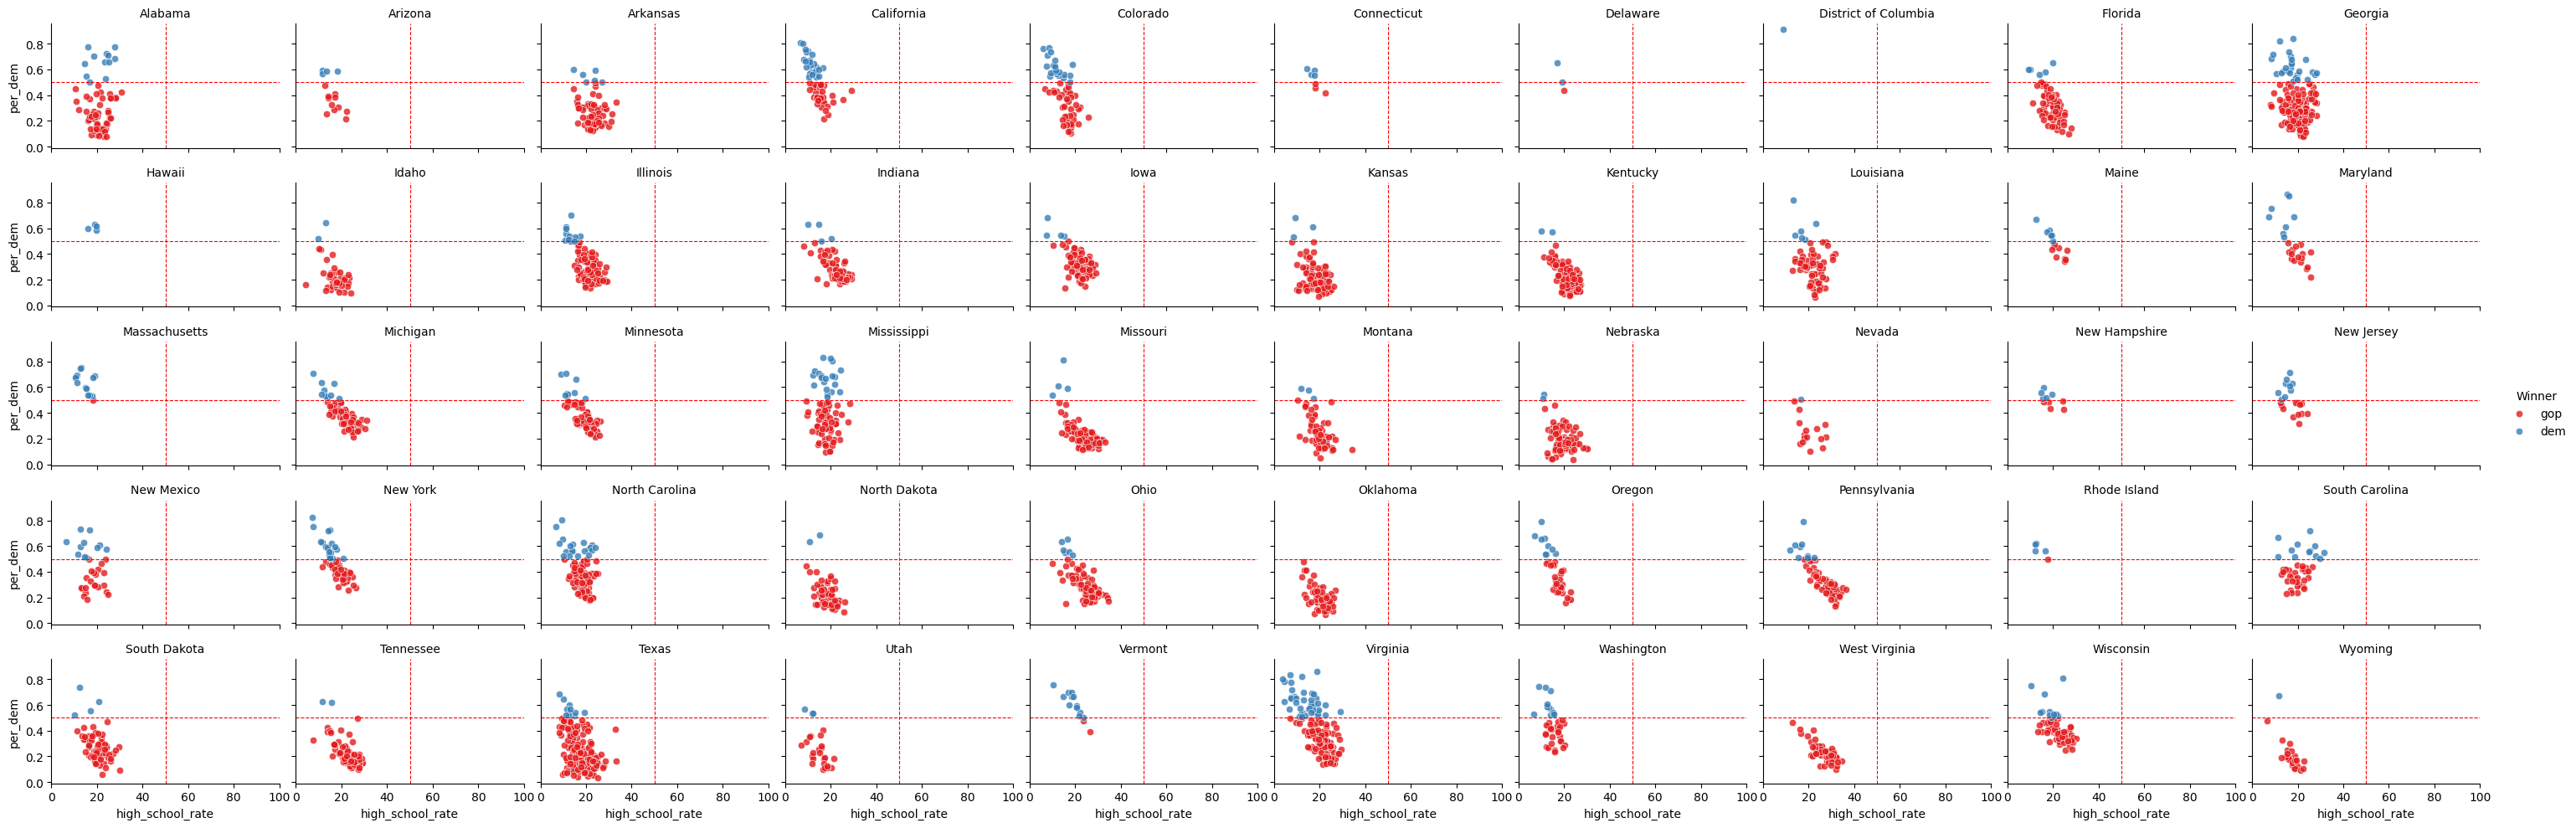

In [50]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner", col_wrap=10, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})
g.map(sns.scatterplot, 'high_school_rate', 'per_dem', alpha=0.8)

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='red', lw=0.8)
    ax.axvline(50, ls='--', color='red', lw=0.8)
    ax.set_xlim(0, 100)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels('high_school_rate', 'per_dem')

plt.show()

##### Porcentaje de población con título universitario (Bachelors) por condado

In [46]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=plot_data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=plot_data['county_fips'],
                    color='bachelors_rate',
                    hover_name=plot_data['county'],
                    scope='usa'
                   )

# Layout sin plantilla y con fondo transparente
fig.update_layout(
    template=None,  # Evita que alguna plantilla añada fondo
    title_text="Ganador por condado",
    title_x=0.5,
    width=1200,
    height=800,
    margin={"r":0, "t":50, "l":0, "b":0},
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

# Quitar (o minimizar) las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.3, marker_line_color="black")

# Cargar geojson de fronteras estatales
url_states = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
states_geojson = requests.get(url_states).json()

# Agregar capa de fronteras de estados con líneas más gruesas
fig.add_trace(go.Choropleth(
    geojson=states_geojson,
    locations=[feature['id'] for feature in states_geojson['features']],
    z=[0] * len(states_geojson['features']),
    colorscale=[[0, 'rgba(0,0,0,0)'], [1, 'rgba(0,0,0,0)']],  # Sin relleno
    marker_line_width=1,        # Grosor de línea aumentado para fronteras estatales
    marker_line_color="black",  # Color de línea
    showscale=False,            # No mostrar escala para esta capa
    hoverinfo='none'            # Ocultar información al pasar el ratón
))

# Ajustar la visualización geográfica
fig.update_geos(
    # Si usas scope='usa', no es imprescindible center ni projection_scale;
    # pero si ves mucho espacio vacío, puedes forzar un escalado.
    scope='usa',
    projection=go.layout.geo.Projection(type='albers usa'),
    showland=True,
    landcolor='rgba(0,0,0,0)',   # Tierra transparente
    showocean=True,
    oceancolor='rgba(0,0,0,0)',  # Océano transparente
    showlakes=True,
    lakecolor='rgba(0,0,0,0)',   # Lagos transparentes
    showrivers=True,
    rivercolor='rgba(0,0,0,0)',  # Ríos transparentes
    bgcolor='rgba(0,0,0,0)'      # Fondo geográfico transparente
)

fig.update_layout(
    coloraxis_showscale=False,  # Ocultar barra de color
    showlegend=False            # Ocultar leyenda
)

# Exportar en PNG y PDF con fondo transparente
fig.write_image("imgs/mapa_county_bachelors.png", scale=10, engine="kaleido")
fig.write_image("imgs/mapa_county_bachelors.pdf", scale=10, engine="kaleido")

# Mostrar en pantalla
fig.show()


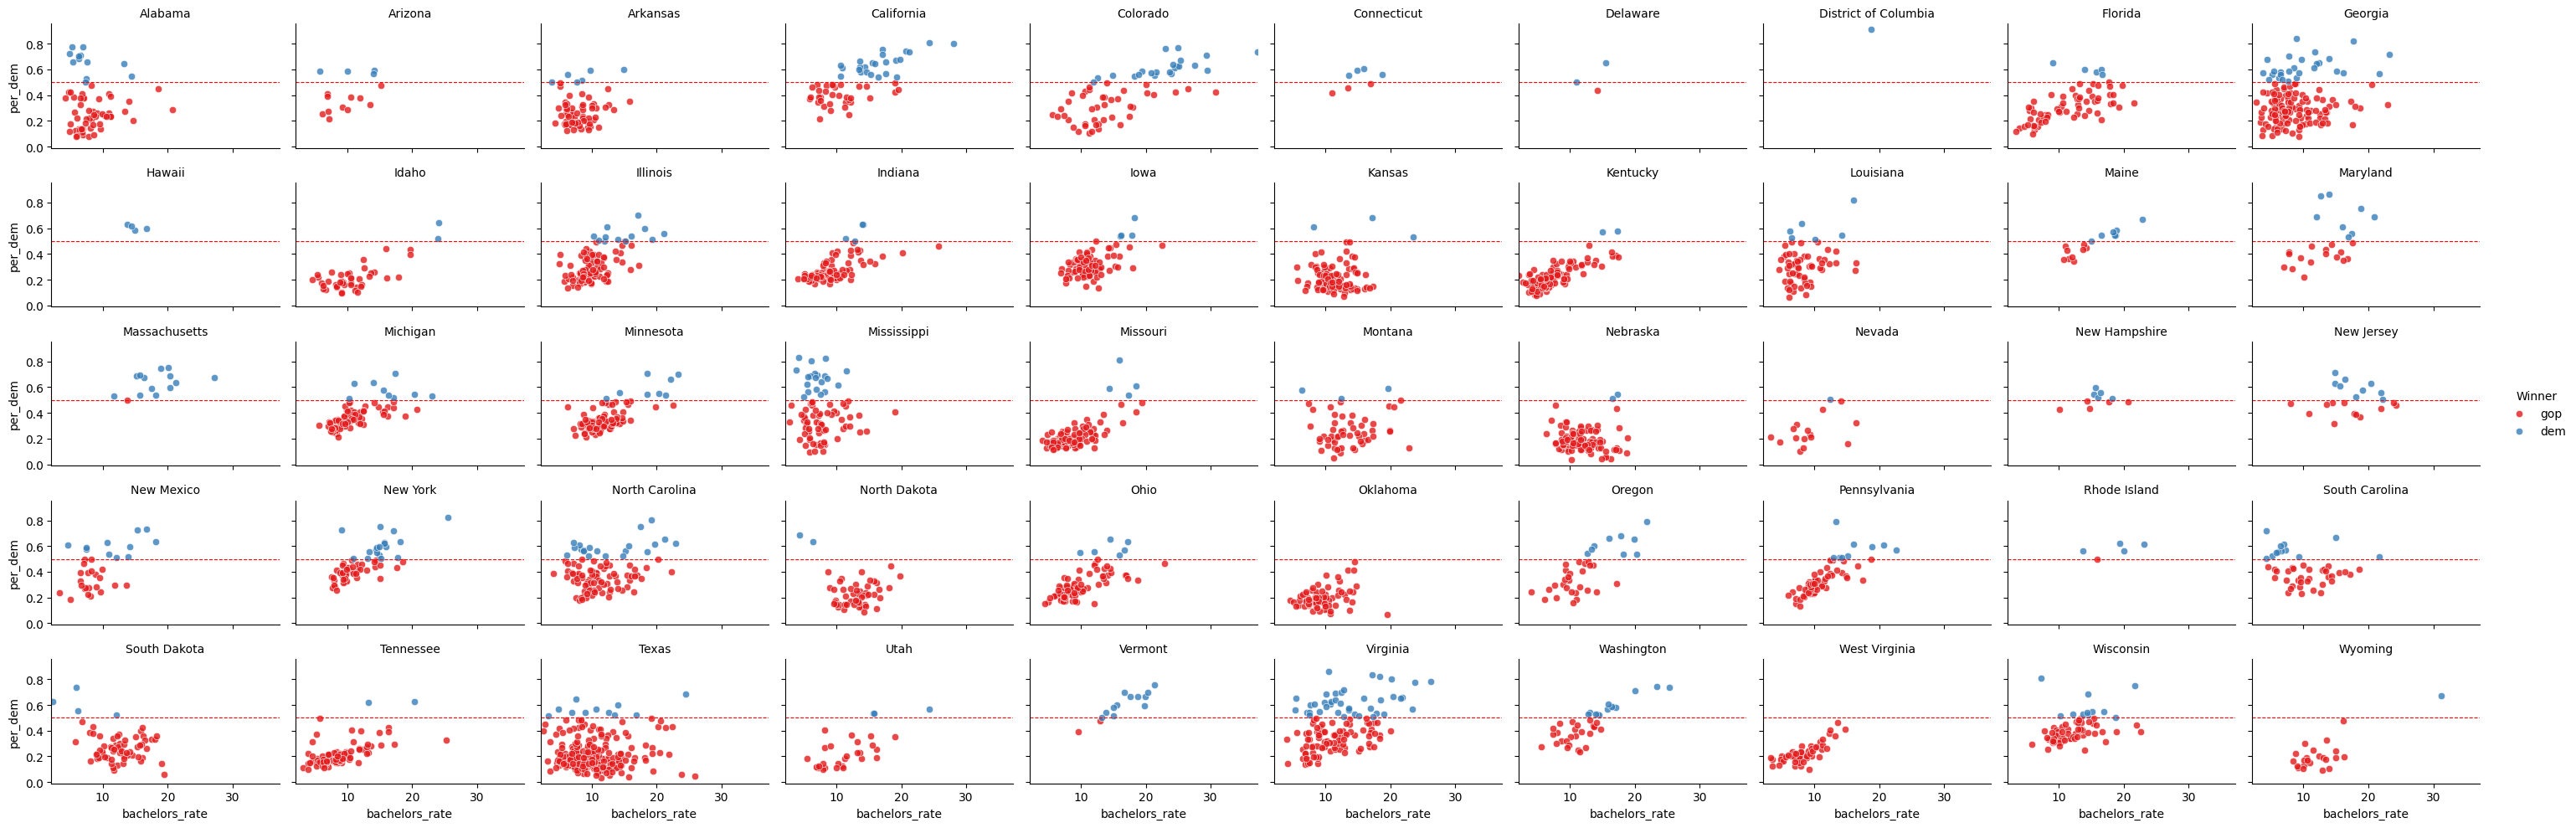

In [51]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner", col_wrap=10, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})
g.map(sns.scatterplot, 'bachelors_rate', 'per_dem', alpha=0.8)

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='red', lw=0.8)
    ax.axvline(50, ls='--', color='red', lw=0.8)
    ax.set_xlim(min(plot_data['bachelors_rate']), max(plot_data['bachelors_rate']))

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels('bachelors_rate', 'per_dem')

plt.show()

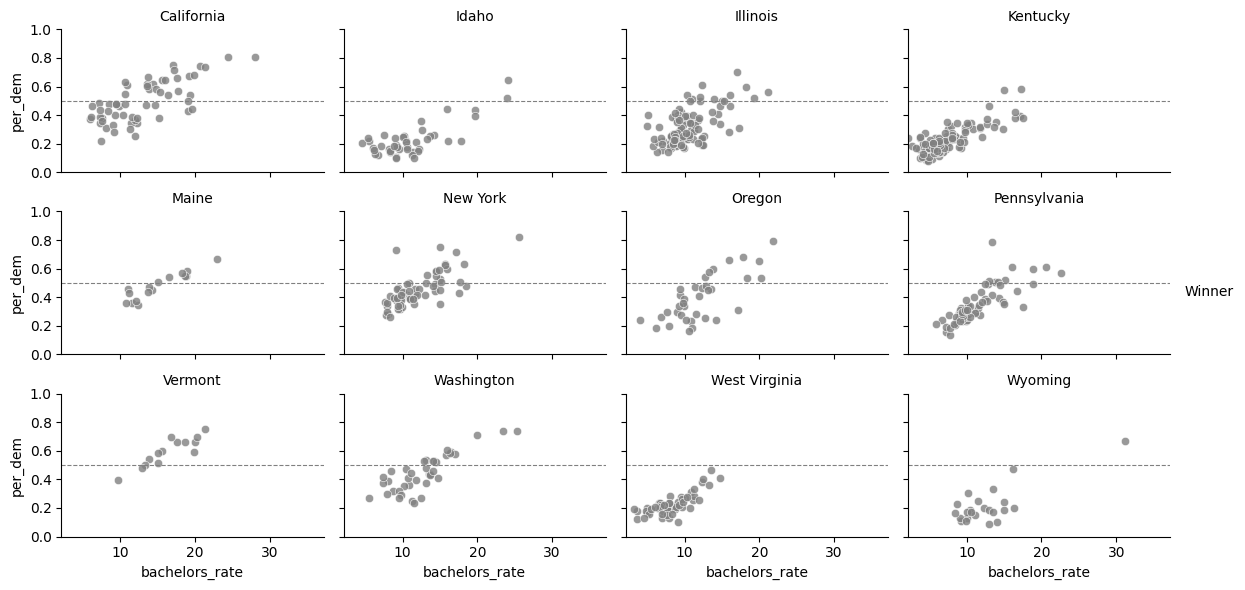

In [72]:
# Lista de estados a mostrar (modifica según tus necesidades)
selected_states = ['California', 'Idaho', 'Illinois', 'Kentucky', 'Maine', 'New York', 'Oregon', 'Pennsylvania', 'Vermont', 'Washington', 'West Virginia', 'Wyoming']

# Filtrar el DataFrame para incluir solo los estados seleccionados
filtered_data = plot_data[plot_data['state'].isin(selected_states)]

# Crear gráfico FacetGrid con los estados filtrados
g = sns.FacetGrid(filtered_data, col='state', col_wrap=int(len(selected_states)//3), 
                  height=2, aspect=1.5)
g.map(sns.scatterplot, 'bachelors_rate', 'per_dem', color="gray", alpha=0.8)

# Añadir líneas horizontales y verticales
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='gray', lw=0.8)
    ax.axvline(50, ls='--', color='gray', lw=0.8)
    ax.set_ylim(0, 1)   # Ajustar el eje X para per_gop (asumiendo que va de 0 a 1)
    ax.set_xlim(min(plot_data['bachelors_rate']), max(plot_data['bachelors_rate']))

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels('bachelors_rate', 'per_dem')

# Guardar el gráfico en PDF y PNG con fondo transparente
g.fig.savefig('imgs/scatter_bachelors_gray.pdf', transparent=True)
g.fig.savefig('imgs/scatter_bachelors_gray.png', transparent=True)

plt.show()


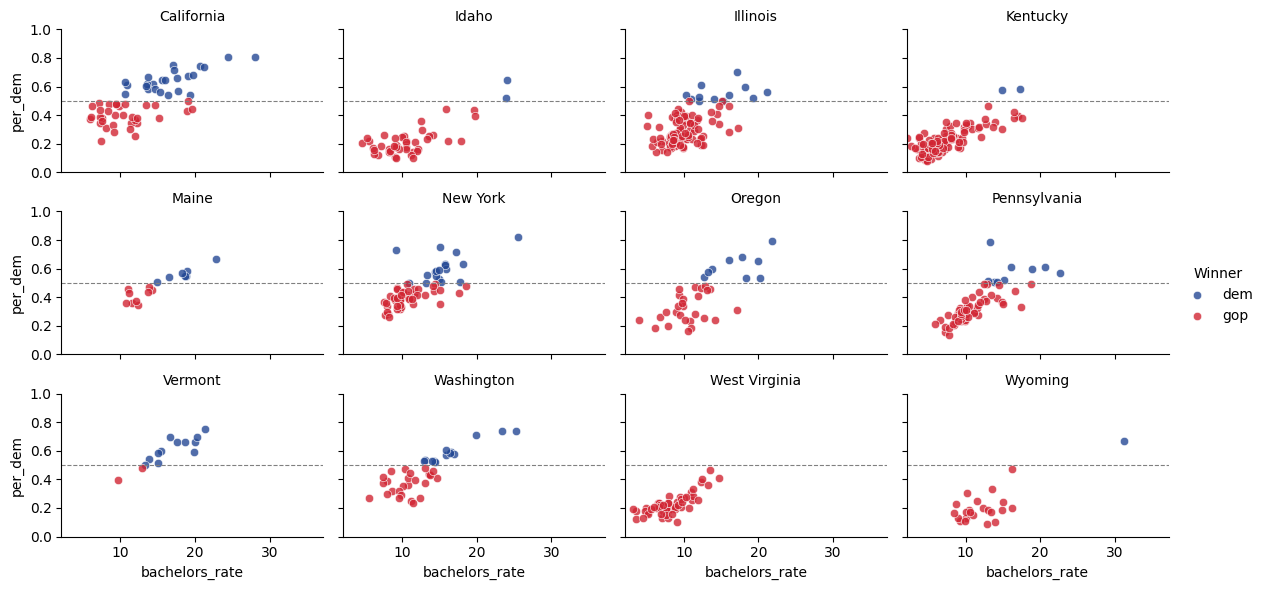

In [71]:
# Lista de estados a mostrar (modifica según tus necesidades)
selected_states = ['California', 'Idaho', 'Illinois', 'Kentucky', 'Maine', 'New York', 'Oregon', 'Pennsylvania', 'Vermont', 'Washington', 'West Virginia', 'Wyoming']

# Filtrar el DataFrame para incluir solo los estados seleccionados
filtered_data = plot_data[plot_data['state'].isin(selected_states)]

# Crear gráfico FacetGrid con los estados filtrados
g = sns.FacetGrid(filtered_data, col='state', hue="winner", col_wrap=int(len(selected_states)//3), 
                  height=2, aspect=1.5, palette={"gop": "#d12533", "dem": "#254995"})
g.map(sns.scatterplot, 'bachelors_rate', 'per_dem', alpha=0.8)

# Añadir líneas horizontales y verticales
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='gray', lw=0.8)
    ax.axvline(50, ls='--', color='gray', lw=0.8)
    ax.set_ylim(0, 1)   # Ajustar el eje X para per_gop (asumiendo que va de 0 a 1)
    ax.set_xlim(min(plot_data['bachelors_rate']), max(plot_data['bachelors_rate']))

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels('bachelors_rate', 'per_dem')

# Guardar el gráfico en PDF y PNG con fondo transparente
g.fig.savefig('imgs/scatter_bachelors.pdf', transparent=True)
g.fig.savefig('imgs/scatter_bachelors.png', transparent=True)

plt.show()


#### Raza y Etnia

##### Porcentaje de población blanca (White) por condado

In [ ]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color='white_rate',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Distribución de la población blanca por condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


In [ ]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner", col_wrap=10, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})
g.map(sns.scatterplot, f"white_rate", 'per_dem', alpha=0.8)

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='red', lw=0.8)
    ax.axvline(50, ls='--', color='gray', lw=0.8)
    ax.set_xlim(0, 100)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels(f"white_rate", 'per_dem')

plt.show()

##### Porcentaje de población negra (Black) por condado

In [40]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=plot_data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=plot_data['county_fips'],
                    color='black_rate',
                    hover_name=plot_data['county'],
                    scope='usa'
                   )


# Layout sin plantilla y con fondo transparente
fig.update_layout(
    template=None,  # Evita que alguna plantilla añada fondo
    title_text="Ganador por condado",
    title_x=0.5,
    width=1200,
    height=800,
    margin={"r":0, "t":50, "l":0, "b":0},
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

# Quitar (o minimizar) las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.3, marker_line_color="black")

# Cargar geojson de fronteras estatales
url_states = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
states_geojson = requests.get(url_states).json()

# Agregar capa de fronteras de estados con líneas más gruesas
fig.add_trace(go.Choropleth(
    geojson=states_geojson,
    locations=[feature['id'] for feature in states_geojson['features']],
    z=[0] * len(states_geojson['features']),
    colorscale=[[0, 'rgba(0,0,0,0)'], [1, 'rgba(0,0,0,0)']],  # Sin relleno
    marker_line_width=1,        # Grosor de línea aumentado para fronteras estatales
    marker_line_color="black",  # Color de línea
    showscale=False,            # No mostrar escala para esta capa
    hoverinfo='none'            # Ocultar información al pasar el ratón
))

# Ajustar la visualización geográfica
fig.update_geos(
    # Si usas scope='usa', no es imprescindible center ni projection_scale;
    # pero si ves mucho espacio vacío, puedes forzar un escalado.
    scope='usa',
    projection=go.layout.geo.Projection(type='albers usa'),
    showland=True,
    landcolor='rgba(0,0,0,0)',   # Tierra transparente
    showocean=True,
    oceancolor='rgba(0,0,0,0)',  # Océano transparente
    showlakes=True,
    lakecolor='rgba(0,0,0,0)',   # Lagos transparentes
    showrivers=True,
    rivercolor='rgba(0,0,0,0)',  # Ríos transparentes
    bgcolor='rgba(0,0,0,0)'      # Fondo geográfico transparente
)

fig.update_layout(
    coloraxis_showscale=False,  # Ocultar barra de color
    showlegend=False            # Ocultar leyenda
)


# Exportar en PNG y PDF con fondo transparente
fig.write_image("imgs/mapa_county_black.png", scale=10, engine="kaleido")
fig.write_image("imgs/mapa_county_black.pdf", scale=10, engine="kaleido")

# Mostrar en pantalla
fig.show()

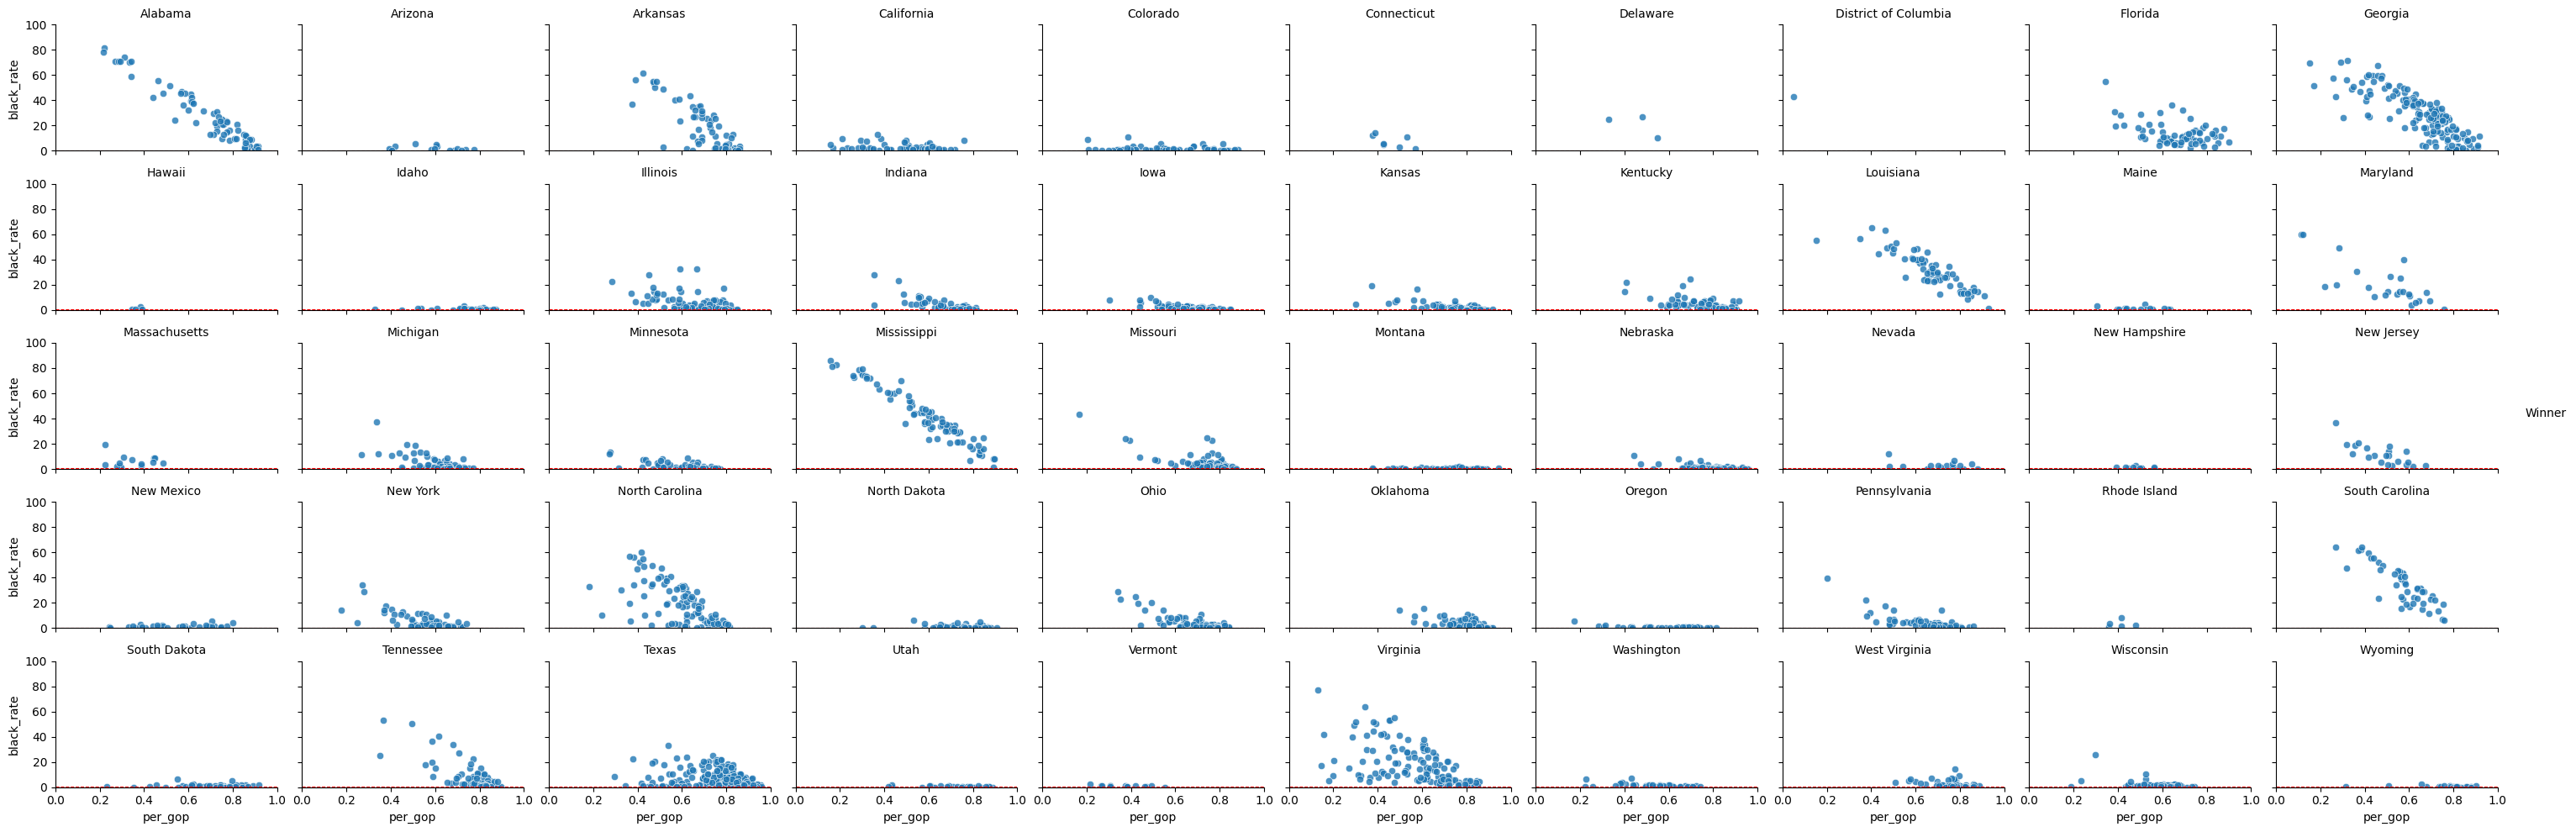

In [57]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', col_wrap=10, height=2, aspect=1.5)
g.map(sns.scatterplot, 'per_gop', 'black_rate', alpha=0.8)

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='red', lw=0.8)
    ax.axvline(50, ls='--', color='gray', lw=0.8)
    ax.set_xlim(0, 1)   # Ajustar el eje X para per_dem (asumiendo que va de 0 a 1)
    ax.set_ylim(0, 100)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels('per_gop', 'black_rate')

plt.show()

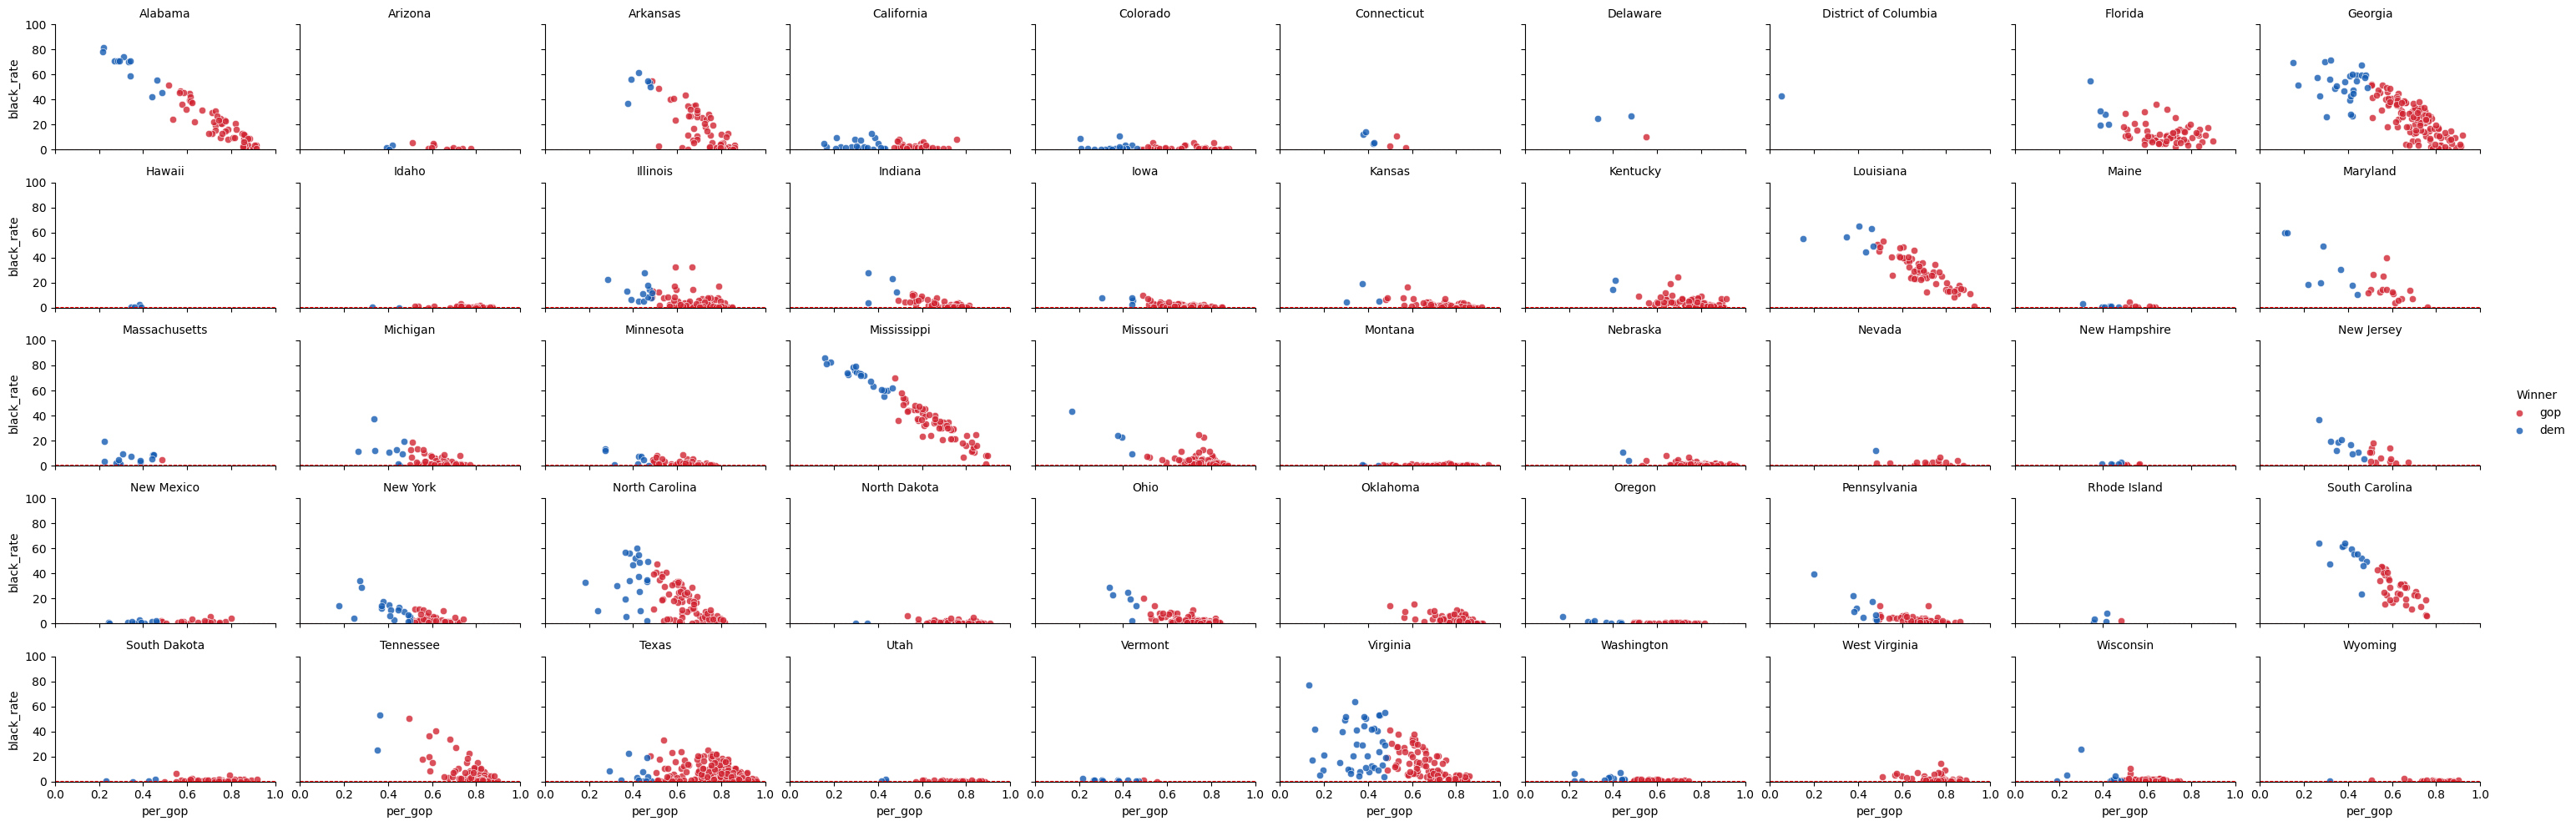

In [58]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner", col_wrap=10, height=2, aspect=1.5, palette={"gop": "#d12533", "dem": "#145bb2"})
g.map(sns.scatterplot, 'per_gop', 'black_rate', alpha=0.8)

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='red', lw=0.8)
    ax.axvline(50, ls='--', color='gray', lw=0.8)
    ax.set_xlim(0, 1)   # Ajustar el eje X para per_dem (asumiendo que va de 0 a 1)
    ax.set_ylim(0, 100)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels('per_gop', 'black_rate')

plt.show()

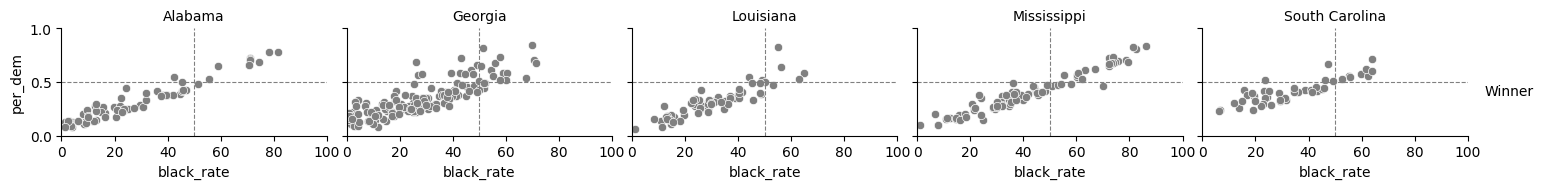

In [59]:
# Lista de estados a mostrar (modifica según tus necesidades)
selected_states = ['Alabama', 'Mississippi', 'Louisiana', 'North Carolina', 'South Carolina', 'Georgia']

# Filtrar el DataFrame para incluir solo los estados seleccionados
filtered_data = plot_data[plot_data['state'].isin(selected_states)]

# Crear gráfico FacetGrid con los estados filtrados
g = sns.FacetGrid(filtered_data, col='state', col_wrap=len(selected_states), 
                  height=2, aspect=1.5)
g.map(sns.scatterplot, 'black_rate', 'per_dem', color="gray", alpha=1)

# Añadir líneas horizontales y verticales
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='gray', lw=0.8)
    ax.axvline(50, ls='--', color='gray', lw=0.8)
    ax.set_ylim(0, 1)   # Ajustar el eje X para per_gop (asumiendo que va de 0 a 1)
    ax.set_xlim(0, 100)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels('black_rate', 'per_dem')

plt.show()


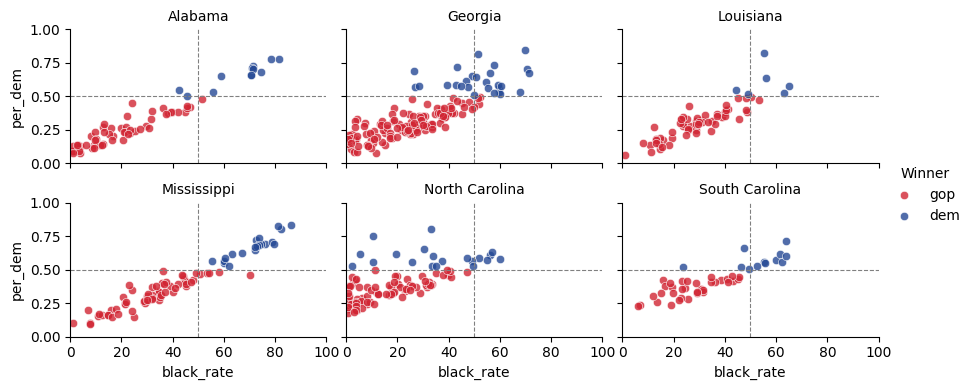

In [65]:
# Lista de estados a mostrar (modifica según tus necesidades)
selected_states = ['Alabama', 'Mississippi', 'Louisiana', 'North Carolina', 'South Carolina', 'Georgia']

# Filtrar el DataFrame para incluir solo los estados seleccionados
filtered_data = plot_data[plot_data['state'].isin(selected_states)]

# Crear gráfico FacetGrid con los estados filtrados
g = sns.FacetGrid(filtered_data, col='state', hue="winner", col_wrap=int(len(selected_states)//2), 
                  height=2, aspect=1.5, palette={"gop": "#d12533", "dem": "#254995"})
g.map(sns.scatterplot, 'black_rate', 'per_dem', alpha=0.8)

# Añadir líneas horizontales y verticales
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='gray', lw=0.8)
    ax.axvline(50, ls='--', color='gray', lw=0.8)
    ax.set_ylim(0, 1)   # Ajustar el eje X para per_gop (asumiendo que va de 0 a 1)
    ax.set_xlim(0, 100)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels('black_rate', 'per_dem')

# Guardar el gráfico en PDF y PNG con fondo transparente
g.fig.savefig('imgs/scatter_black.pdf', transparent=True)
g.fig.savefig('imgs/scatter_black.png', transparent=True)

plt.show()


##### Porcentaje de población hispana (Hispanic) por condado

In [ ]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color='hispanic_rate',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Distribución de la población hispana por condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


In [ ]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner", col_wrap=10, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})
g.map(sns.scatterplot, f"hispanic_rate", f"per_dem", alpha=0.8)

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='red', lw=0.8)
    ax.axvline(50, ls='--', color='gray', lw=0.8)
    ax.set_xlim(0, 100)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels(f"hispanic_rate", f"per_dem")

plt.show()

##### Porcentaje de población asiática (Asian) por condado

In [ ]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color='asian_rate',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Distribución de la población asiática por condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


In [ ]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner", col_wrap=10, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})
g.map(sns.scatterplot, 'asian_rate', 'per_dem', alpha=0.8)

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='red', lw=0.8)
    ax.axvline(50, ls='--', color='gray', lw=0.8)
    ax.set_xlim(0, 100)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels('asian_rate', 'per_dem')

plt.show()

##### Porcentaje de población nativa (Native) por condado

In [ ]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color='native_rate',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Distribución de la población nativa por condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


In [ ]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner", col_wrap=10, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})
g.map(sns.scatterplot, 'native_rate', 'per_dem', alpha=0.8)

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='red', lw=0.8)
    ax.axvline(50, ls='--', color='gray', lw=0.8)
    ax.set_xlim(0, 100)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels('native_rate', 'per_dem')

plt.show()

#### Economía

##### Median income

In [ ]:
plot_data['median_income']

In [45]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=plot_data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=plot_data['county_fips'],
                    color=plot_data['median_income'],
                    hover_name=plot_data['county'],
                    scope='usa',
                    range_color=(0, plot_data['median_income'].max())
                   )

# Layout sin plantilla y con fondo transparente
fig.update_layout(
    template=None,  # Evita que alguna plantilla añada fondo
    title_text="Ganador por condado",
    title_x=0.5,
    width=1200,
    height=800,
    margin={"r":0, "t":50, "l":0, "b":0},
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

# Quitar (o minimizar) las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.3, marker_line_color="black")

# Cargar geojson de fronteras estatales
url_states = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
states_geojson = requests.get(url_states).json()

# Agregar capa de fronteras de estados con líneas más gruesas
fig.add_trace(go.Choropleth(
    geojson=states_geojson,
    locations=[feature['id'] for feature in states_geojson['features']],
    z=[0] * len(states_geojson['features']),
    colorscale=[[0, 'rgba(0,0,0,0)'], [1, 'rgba(0,0,0,0)']],  # Sin relleno
    marker_line_width=1,        # Grosor de línea aumentado para fronteras estatales
    marker_line_color="black",  # Color de línea
    showscale=False,            # No mostrar escala para esta capa
    hoverinfo='none'            # Ocultar información al pasar el ratón
))

# Ajustar la visualización geográfica
fig.update_geos(
    # Si usas scope='usa', no es imprescindible center ni projection_scale;
    # pero si ves mucho espacio vacío, puedes forzar un escalado.
    scope='usa',
    projection=go.layout.geo.Projection(type='albers usa'),
    showland=True,
    landcolor='rgba(0,0,0,0)',   # Tierra transparente
    showocean=True,
    oceancolor='rgba(0,0,0,0)',  # Océano transparente
    showlakes=True,
    lakecolor='rgba(0,0,0,0)',   # Lagos transparentes
    showrivers=True,
    rivercolor='rgba(0,0,0,0)',  # Ríos transparentes
    bgcolor='rgba(0,0,0,0)'      # Fondo geográfico transparente
)

fig.update_layout(
    coloraxis_showscale=False,  # Ocultar barra de color
    showlegend=False            # Ocultar leyenda
)


# Exportar en PNG y PDF con fondo transparente
fig.write_image("imgs/mapa_county_median_income.png", scale=10, engine="kaleido")
fig.write_image("imgs/mapa_county_median_income.pdf", scale=10, engine="kaleido")

# Mostrar en pantalla
fig.show()


In [ ]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data[plot_data['median_income']>=0], col='state', hue=f"winner", col_wrap=6, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})
g.map(sns.scatterplot, 'median_income', 'per_dem', alpha=0.8)

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='red', lw=0.8)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels('median_income', 'per_dem')

plt.show()

##### Tasa de Desempleo

In [ ]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=plot_data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color='unemployment_rate',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Distribución de la tasa de desempleo por cada condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


In [ ]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner", col_wrap=6, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})
g.map(sns.scatterplot, 'unemployment_rate', 'per_dem', alpha=0.8)

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='red', lw=0.8)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels('unemployment_rate', 'per_dem')

plt.show()

#### Tamaño medio de familia

In [ ]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=plot_data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color='households_avg_size',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Distribución del tamaño medio de familia por cada condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


In [ ]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner", col_wrap=6, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})
g.map(sns.scatterplot, 'households_avg_size', 'per_dem', alpha=0.8)

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='red', lw=0.8)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels('households_avg_size', 'per_dem')

plt.show()

## GIFs

#### Winner -> Black

In [95]:
from PIL import Image

# Cargar las dos imágenes
img1 = Image.open("imgs/mapa_county_black.png").convert("RGBA")
img2 = Image.open("imgs/mapa_county_state_winner.png").convert("RGBA")

# Cantidad de fotogramas en la transición
num_frames = 30

frames = []
for i in range(num_frames+1):
    alpha = i / num_frames  # Va de 0 a 1
    # Combinar imágenes con un factor alpha
    blend = Image.blend(img1, img2, alpha=alpha)
    frames.append(blend)

# Guardar como GIF animado
frames[0].save(
    "imgs/transicion_winner_black_2.gif",
    save_all=True,
    append_images=frames[1:],
    duration=100,  # milisegundos por fotograma
    loop=0
)


#### Winner -> Median Income

In [96]:
from PIL import Image

# Cargar las dos imágenes
img1 = Image.open("imgs/mapa_county_median_income.png").convert("RGBA")
img2 = Image.open("imgs/mapa_county_state_winner.png").convert("RGBA")

# Cantidad de fotogramas en la transición
num_frames = 30

frames = []
for i in range(num_frames+1):
    alpha = i / num_frames  # Va de 0 a 1
    # Combinar imágenes con un factor alpha
    blend = Image.blend(img2, img1, alpha=alpha)
    frames.append(blend)

# Guardar como GIF animado
frames[0].save(
    "imgs/transicion_winner_median_income.gif",
    save_all=True,
    append_images=frames[1:],
    duration=100,  # milisegundos por fotograma
    loop=0
)


#### Winner -> Bachelors

In [97]:
from PIL import Image

# Cargar las dos imágenes
img1 = Image.open("imgs/mapa_county_bachelors.png").convert("RGBA")
img2 = Image.open("imgs/mapa_county_state_winner.png").convert("RGBA")

# Cantidad de fotogramas en la transición
num_frames = 30

frames = []
for i in range(num_frames+1):
    alpha = i / num_frames  # Va de 0 a 1
    # Combinar imágenes con un factor alpha
    blend = Image.blend(img2, img1, alpha=alpha)
    frames.append(blend)

# Guardar como GIF animado
frames[0].save(
    "imgs/transicion_winner_bachelors.gif",
    save_all=True,
    append_images=frames[1:],
    duration=100,  # milisegundos por fotograma
    loop=0
)
